In [ ]:
from google.colab import drive

In [ ]:
!git clone https://github.com/zzh8829/yolov3-tf2

Cloning into 'yolov3-tf2'...
remote: Enumerating objects: 394, done.
remote: Total 394 (delta 0), reused 0 (delta 0), pack-reused 394
Receiving objects: 100% (394/394), 4.22 MiB | 34.06 MiB/s, done.
Resolving deltas: 100% (230/230), done.


In [ ]:
%cd yolov3-tf2
!ls

/content/yolov3-tf2
checkpoints	 data		  README.md		train.py
colab_gpu.ipynb  detect.py	  requirements-gpu.txt	yolov3_tf2
conda-cpu.yml	 detect_video.py  requirements.txt
conda-gpu.yml	 docs		  setup.py
convert.py	 LICENSE	  tools


In [ ]:
!ls data
print('coco.names')
!cat data/coco.names | wc
print('voc2012.names')
!cat data/voc2012.names | wc
!cat data/coco.names

checkpoint  girl.png	meme.jpg      street.jpg      voc2012.names
coco.names  meme2.jpeg	meme_out.jpg  street_out.jpg
coco.names
     80      93     625
voc2012.names
     20      20     135
person
bicycle
car
motorbike
aeroplane
bus
train
truck
boat
traffic light
fire hydrant
stop sign
parking meter
bench
bird
cat
dog
horse
sheep
cow
elephant
bear
zebra
giraffe
backpack
umbrella
handbag
tie
suitcase
frisbee
skis
snowboard
sports ball
kite
baseball bat
baseball glove
skateboard
surfboard
tennis racket
bottle
wine glass
cup
fork
knife
spoon
bowl
banana
apple
sandwich
orange
broccoli
carrot
hot dog
pizza
donut
cake
chair
sofa
pottedplant
bed
diningtable
toilet
tvmonitor
laptop
mouse
remote
keyboard
cell phone
microwave
oven
toaster
sink
refrigerator
book
clock
vase
scissors
teddy bear
hair drier
toothbrush


In [ ]:
!pip install -r requirements-gpu.txt

Obtaining file:///content/yolov3-tf2 (from -r requirements-gpu.txt (line 6))
     |████████████████████████████████| 421.9MB 22kB/s 
     |████████████████████████████████| 28.7MB 120kB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 3.9MB 45.5MB/s 
     |████████████████████████████████| 450kB 52.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=eb215f8336d3a516e3a4e906ecbedabe132dc84ccd946d7667d051237beb4ad2
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement keras-preprocessing<1.2,>=1.1.1, but you'll have keras-preprocessing 1.1.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll

In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

print(tf.__version__)

2.1.2


In [ ]:
!cat convert.py # this function use to convert official yolov3 weights to Keras model|

from absl import app, flags, logging
from absl.flags import FLAGS
import numpy as np
from yolov3_tf2.models import YoloV3, YoloV3Tiny
from yolov3_tf2.utils import load_darknet_weights
import tensorflow as tf

flags.DEFINE_string('weights', './data/yolov3.weights', 'path to weights file')
flags.DEFINE_string('output', './checkpoints/yolov3.tf', 'path to output')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')


def main(_argv):
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)

    if FLAGS.tiny:
        yolo = YoloV3Tiny(classes=FLAGS.num_classes)
    else:
        yolo = YoloV3(classes=FLAGS.num_classes)
    yolo.summary()
    logging.info('model created')

    load_darknet_weights(yolo, FLAGS.weights, FLAGS.tiny)
    logging.info('weights loaded')

    img = np.rand

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!python convert.py

--2020-12-03 12:18:29--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘data/yolov3.weights’

data/yolov3.weights 100%[===================>] 236.52M   589KB/s    in 7m 31s  

2020-12-03 12:26:01 (538 KB/s) - ‘data/yolov3.weights’ saved [248007048/248007048]

2020-12-03 12:26:02.322738: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-12-03 12:26:02.322852: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directo

In [ ]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs
from IPython.display import Image, display

In [ ]:
flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

['yolov3']

In [ ]:
# trick to better allocate GPU memory, otherwise, we will get OOM
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

In [ ]:
FLAGS.tiny, FLAGS.classes

(False, './data/coco.names')

In [ ]:
if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)
      
yolo.load_weights(FLAGS.weights).expect_partial() # expect_partial just suppress some loading warning
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

I1203 12:29:04.113743 140343507109760 <ipython-input-16-92001a951765>:7] weights loaded
I1203 12:29:04.115187 140343507109760 <ipython-input-16-92001a951765>:10] classes loaded


In [ ]:
print(class_names)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [ ]:
flickr_path = '/content/drive/MyDrive/Colab Notebooks/flickr8k-sau/Flickr_Data/Images/'
paths2 = sorted(os.listdir(flickr_path))
print(len(paths2))

8104


I1203 13:58:13.511486 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	person, 0.9952714443206787, [0.01828443 0.29917288 0.27892715 0.6485461 ]


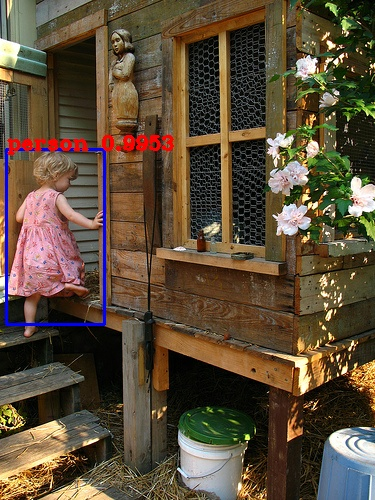

I1203 13:58:13.757996 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	dog, 0.9990652799606323, [0.         0.         0.38150644 0.4028828 ]
I1203 13:58:13.763558 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	dog, 0.9953919649124146, [0.48225948 0.22900847 0.8593894  0.987329  ]


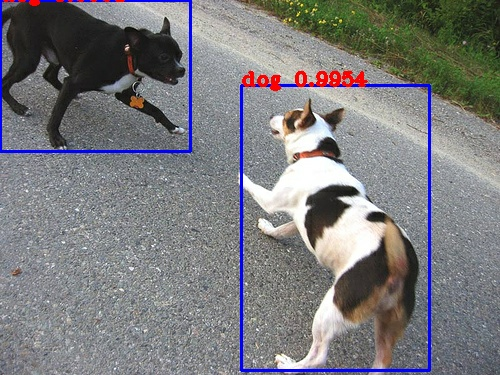

I1203 13:58:14.005020 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	person, 0.9327067136764526, [0.21078652 0.5804466  0.38444376 0.91460633]


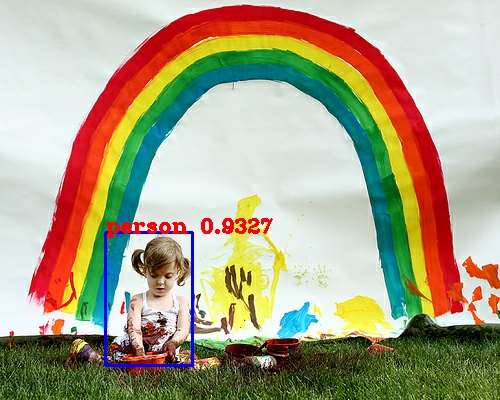

I1203 13:58:14.258035 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	dog, 0.9931276440620422, [0.19606793 0.6436292  0.39828157 0.950145  ]
I1203 13:58:14.263611 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	bench, 0.9592118859291077, [0.10141507 0.4125916  0.7431122  0.90495336]
I1203 13:58:14.268382 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	person, 0.8917660713195801, [0.22262079 0.19857882 0.7453571  0.62316793]


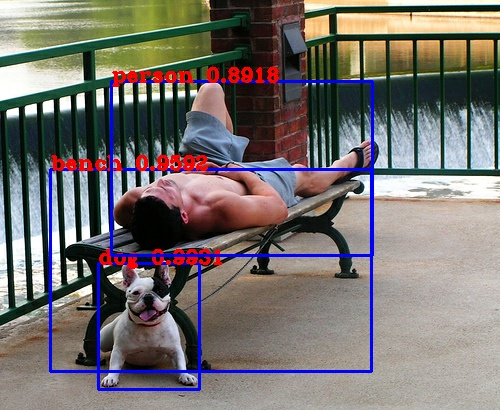

I1203 13:58:14.505671 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	person, 0.9998303651809692, [0.09776902 0.11733884 0.93082666 0.99973935]
I1203 13:58:14.509864 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	person, 0.7477544546127319, [0.         0.29217824 0.12817384 0.975103  ]
I1203 13:58:14.513385 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	person, 0.634719729423523, [0.8050202 0.6452265 0.9991356 0.9451786]
I1203 13:58:14.517361 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	person, 0.6330786347389221, [0.05335081 0.5684463  0.2966178  0.87620354]


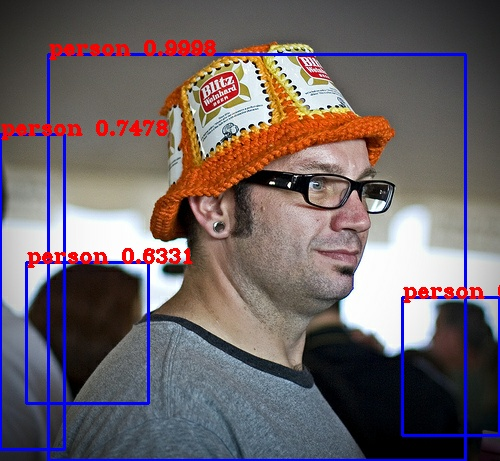

I1203 13:58:14.772183 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	person, 0.6766510605812073, [0.3849986  0.01470989 0.77949774 0.9960843 ]


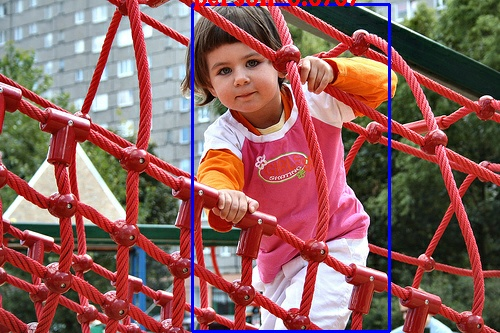

I1203 13:58:15.052382 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	dog, 0.9989644885063171, [0.4606924  0.21140629 0.79654384 0.5000148 ]


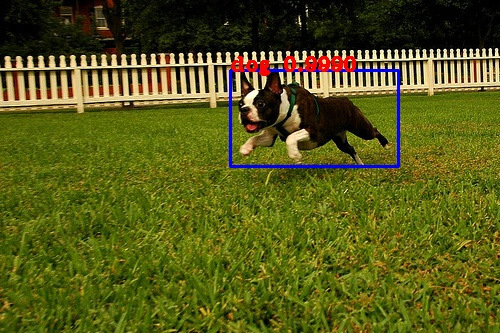

I1203 13:58:15.297593 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	sports ball, 0.9991984963417053, [0.4884094  0.7158586  0.5816567  0.83925545]
I1203 13:58:15.303522 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	dog, 0.996363639831543, [0.30614686 0.07250175 0.72497714 0.87329113]


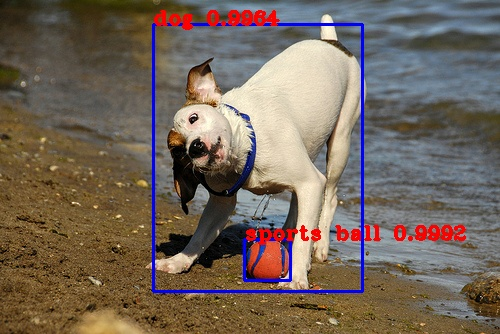

I1203 13:58:15.542486 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	person, 0.9933309555053711, [0.30373144 0.01874262 0.58116156 1.        ]
I1203 13:58:15.547764 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	person, 0.9361065030097961, [0.35641152 0.         0.6268338  0.70684636]
I1203 13:58:15.552897 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	pottedplant, 0.8034725189208984, [0.02138352 0.0007561  0.1693081  0.08886075]
I1203 13:58:15.557845 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	pottedplant, 0.7415473461151123, [0.16975975 0.00072696 0.3375672  0.09074403]


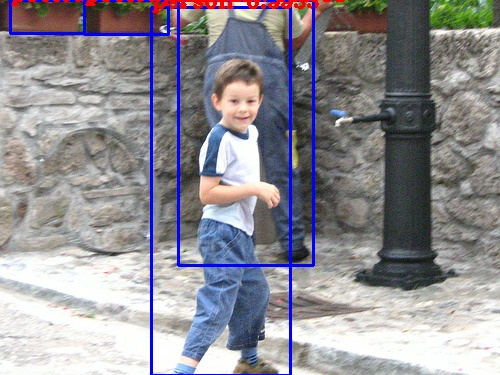

I1203 13:58:15.806173 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	dog, 0.9986047148704529, [0.45606297 0.08380723 0.7177406  0.6100628 ]


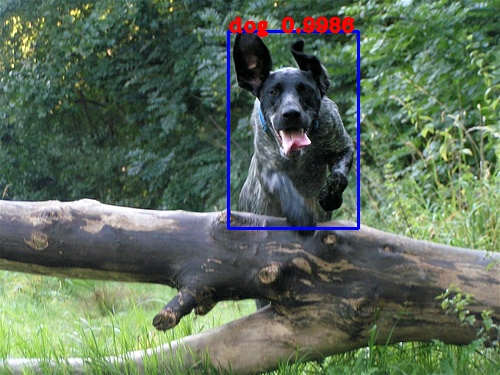

I1203 13:58:16.050789 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	dog, 0.997175395488739, [0.38572228 0.3068416  0.8734938  0.9017458 ]


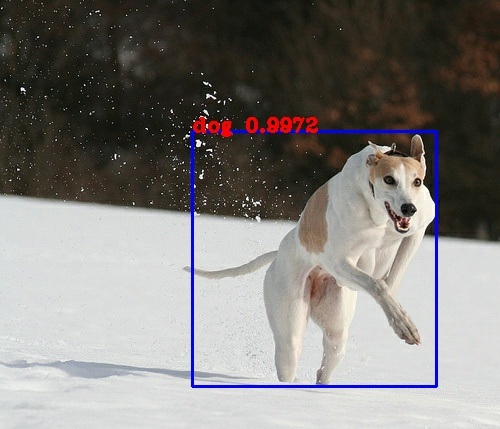

I1203 13:58:16.293524 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	person, 0.9983410239219666, [0.7190345  0.2904582  0.92972904 0.8769803 ]
I1203 13:58:16.299229 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	person, 0.9648765921592712, [0.04890314 0.21875566 0.19320849 0.8219139 ]
I1203 13:58:16.304280 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	skis, 0.5352279543876648, [0.64745814 0.8468435  0.93766385 0.91025877]


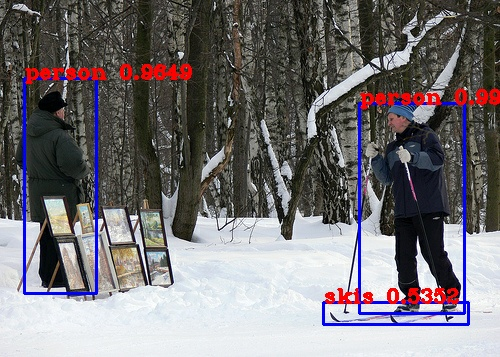

I1203 13:58:16.552386 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	person, 0.9991327524185181, [0.21875834 0.605386   0.49706936 0.98375654]
I1203 13:58:16.557664 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	person, 0.9873573780059814, [0.5644858  0.47313765 0.6908376  0.6201496 ]
I1203 13:58:16.561846 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	person, 0.9853147864341736, [0.6303624  0.61499584 0.7721753  0.77778876]
I1203 13:58:16.566821 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	person, 0.9766638875007629, [0.4939857  0.40653187 0.5906282  0.5249318 ]
I1203 13:58:16.570811 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	person, 0.9435093998908997, [0.57755816 0.73918706 0.68084943 0.90288824]
I1203 13:58:16.575798 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	person, 0.7743313908576965, [0.52466273 0.3215332  0.6822438  0.4247235 ]
I1203 13:58:16.579863 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	person, 0.6136491894721985, [0.

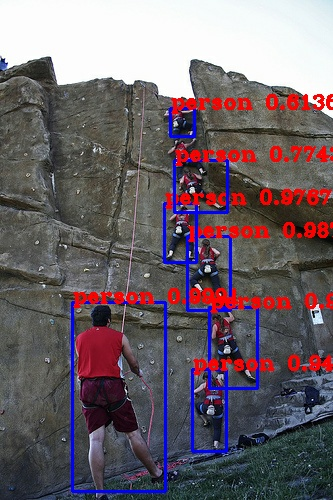

I1203 13:58:16.839092 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	dog, 0.9947732090950012, [0.20078954 0.482032   0.42994556 0.6908999 ]
I1203 13:58:16.844712 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	car, 0.9621768593788147, [0.500026   0.22893563 0.64366007 0.28172824]


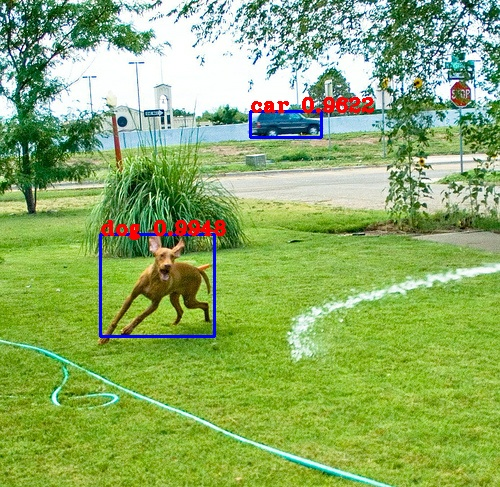

I1203 13:58:17.132869 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	dog, 0.9940778613090515, [0.2088492  0.34537116 0.678829   1.        ]
I1203 13:58:17.138436 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	car, 0.9422751665115356, [0.00701188 0.12418532 0.4194886  0.45936793]


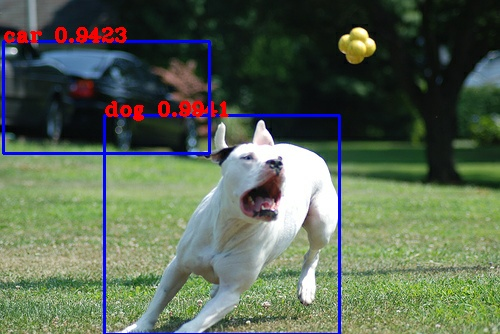

I1203 13:58:17.379047 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	dog, 0.9818940758705139, [0.40265062 0.31439203 0.5556277  0.86961   ]
I1203 13:58:17.384476 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	sports ball, 0.6445451378822327, [0.50882226 0.2558507  0.53379005 0.2964619 ]


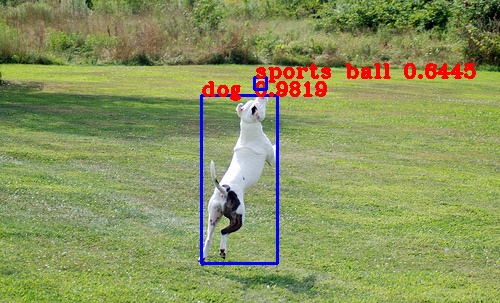

I1203 13:58:17.622504 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	person, 0.9965429306030273, [0.54022694 0.5591617  0.76377    0.99392   ]
I1203 13:58:17.627640 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	person, 0.9662120938301086, [0.6698521 0.7914637 0.9162405 1.       ]


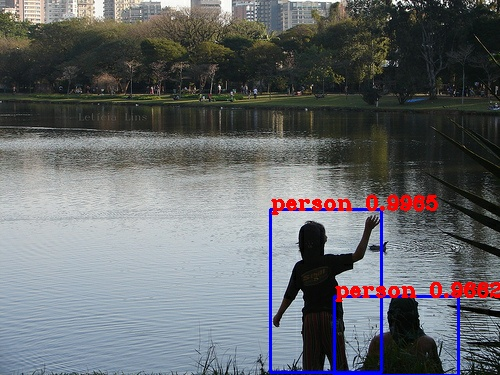

I1203 13:58:17.874816 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	person, 0.9989917278289795, [0.32998902 0.26989743 0.6752272  0.9969038 ]


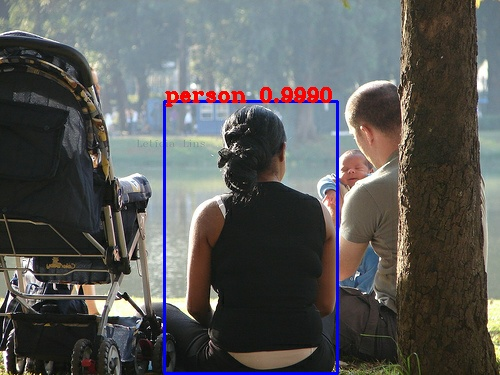

I1203 13:58:18.109025 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	dog, 0.9988427758216858, [0.5348559 0.        0.9516781 0.7190067]


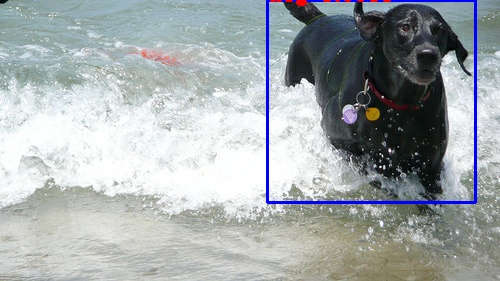

I1203 13:58:18.347282 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	person, 0.9978083372116089, [0.19004454 0.04944566 0.26081187 0.4610813 ]
I1203 13:58:18.353059 140343507109760 <ipython-input-28-eafe17c445d9>:29] 	person, 0.9958826899528503, [0.3905424  0.05581069 0.50863147 0.7514348 ]


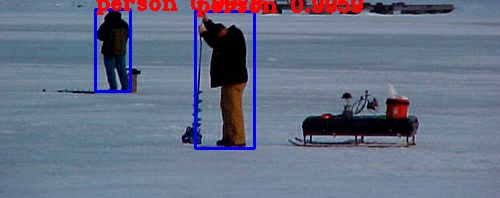

In [ ]:
'''
girl.png  meme2.jpeg    street.jpg	    
meme.jpg  meme_out.jpg  street_out.jpg 
'''
FLAGS.image = 'data/meme.jpg'
FLAGS.image = 'data/meme2.jpeg'
FLAGS.image = 'data/girl.png'
FLAGS.image = 'data/street.jpg'


for jj in range(20):
    FLAGS.image = flickr_path + paths2[jj]

    img_raw = tf.image.decode_image(
        open(FLAGS.image, 'rb').read(), channels=3)

    img = tf.expand_dims(img_raw, 0)
    img = transform_images(img, FLAGS.size)

    t1 = time.time()
    boxes, scores, classes, nums = yolo(img)
    t2 = time.time()
#     logging.info('time: {}'.format(t2 - t1))

#     logging.info('detections:')
    for i in range(nums[0]):
        logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

    
    display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))


In [ ]:
nums_np = nums[0].numpy()
print(nums_np)

score_np = scores[0].numpy()
print(score_np[:(nums[0].numpy()+1)])

classes_np = classes[0].numpy().astype(int)
print(classes_np)

2
[0.99780834 0.9958827  0.        ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
## see the details of drawing function
!cat yolov3_tf2/utils.py

from absl import logging
import numpy as np
import tensorflow as tf
import cv2

YOLOV3_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
    'yolo_conv_2',
    'yolo_output_2',
]

YOLOV3_TINY_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
]


def load_darknet_weights(model, weights_file, tiny=False):
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

    if tiny:
        layers = YOLOV3_TINY_LAYER_LIST
    else:
        layers = YOLOV3_LAYER_LIST

    for layer_name in layers:
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and \
                    sub_model.layers[i + 1].name.startswith('ba

In [ ]:
for i in range(nums_np):
    print(class_names[classes_np[i]]) # Note that Person = class0

person
person


In [ ]:
from imutils.video import VideoStream
from imutils.video import FPS
import numpy as np
import argparse
import imutils
import time
import cv2

In [ ]:
ap = argparse.ArgumentParser()
ap.add_argument("-p", "--prototxt", required=True,
	help="path to Caffe 'deploy' prototxt file")
ap.add_argument("-m", "--model", required=True,
	help="path to Caffe pre-trained model")
ap.add_argument("-c", "--confidence", type=float, default=0.2,
	help="minimum probability to filter weak detections")
args = vars(ap.parse_args())

usage: ipykernel_launcher.py [-h] -p PROTOTXT -m MODEL [-c CONFIDENCE]
ipykernel_launcher.py: error: the following arguments are required: -p/--prototxt, -m/--model


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
